In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

# Root directory of the project
ROOT_DIR = ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

/home/qisens/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/qisens/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/qisens/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/qisens/anaconda3/envs/ten

In [2]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "part"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + 2 classes (damage, scratch)

    # Use smaller images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9



In [72]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        print("load_custom")
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        #add_class(source, class_id, class_name)
        self.add_class("part", 1, "scratch")
        self.add_class("part", 2, "damage")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # !!파일 바꿔주기!!
        annotations = json.load(open(os.path.join(dataset_dir, "via_export_" + subset + ".json")))

        # print(annotations1)
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        class_nums = {'scratch': 1, 'dent': 2}

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            #for r in a['regions']:
                #polygons = [{'all_points_x': r['shape_attributes']['all_points_x'], 'all_points_y': r['shape_attributes']['all_points_y']}]
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes'] for s in a['regions']]
            #num_ids = [int(class_nums[n['name']]) for n in objects]
            num_ids = []
            for n in objects:
                try:
                    if n['name'] == 'scratch':
                        num_ids.append(1)
                    elif n['name'] == 'damage':
                        num_ids.append(2)

                except:
                    pass
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            #add_image(source, image_id, path, **kwargs)
            self.add_image(
                "part",  # for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)


    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        print("load_mask")
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        # print("info['num_ids']=", info['num_ids'])
        # Map class names to class IDs.
        num_ids = info['num_ids']
        return info, mask.astype(np.bool), num_ids.astype(np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "part":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [73]:
config = CustomConfig()

In [74]:
dataset_train = CustomDataset()
dataset_train.load_custom("dataset", "train")
dataset_train.prepare()

load_custom


In [75]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model
import mrcnn.model as modellib
from mrcnn.model import log
import cv2
import imgaug,h5py,IPython

In [76]:
image_ids = np.random.choice(dataset_train.image_ids, 2)

In [78]:
image = dataset_train.load_image(image_ids[0])

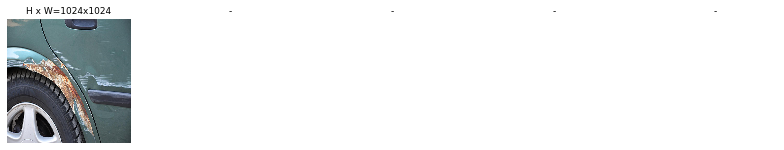

In [79]:
mask, class_ids = dataset_train.load_mask(image_ids[0])
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [39]:
image_id = image_ids[0]

NameError: name 'image_info' is not defined